# MTH3302 : Méthodes probabilistes et statistiques pour l'I.A.

Jonathan Jalbert<br/>
Professeur agrégé au Département de mathématiques et de génie industriel<br/>
Polytechnique Montréal<br/>

Les images proviennent du jeu de données publiques *The Extended Yale Face Database B* disponible sur le site http://vision.ucsd.edu/~iskwak/ExtYaleDatabase/ExtYaleB.html.


## TD6 : Reconnaissance faciale avec l'analyse en composantes principales


Nous utiliserons des images récupérées de la base de données publique de Yale$^{(1)}$ que vous pouvez trouver sur Moodle. 

L'ensemble d'entraînement est composé de 28 images par individu pour 28 individus. 

L'ensemble de test est composé de 69 images non contenues dans l'ensemble d'entraînement.

Pour chaque image de l'ensemble de test, on souhaite déterminer s'il s'agit d'une personne connue dans l'ensemble d'entraînement ou s'il s'agit d'une personne inconnue de l'ensemble d'entraînement.

## Préambule

Plusieurs librairies que nous n'utilisons pas régulièrement dans le cours sont nécessaire. Exécutez la prochaine cellule de code pour installer ces librairies.

In [1]:
import Pkg
Pkg.add(["Images", "Netpbm", "ImageMagick", "Colors"])

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`


In [2]:
# Librairies standards du cours
using Statistics, LinearAlgebra, Gadfly, DataFrames

# Librairie pour le traitement des images
using Images, Netpbm, ImageMagick, Colors

## Fonctions utiles

Voici une liste de fonctions qui vous seront utiles pour ce TD.
- `imgrayconvert` : permet de convertir une image en niveaux de gris pour chacun des pixels
- `imshow` : affiche la matrice d'intensité des niveaux de gris 

In [3]:
"""
    imgrayconvert(imageFileName ; columnStack=true)

Conversion en intensité de gris de l'image du fichier `imageFileName`.

### Arguments
- `imageFileName::string` : le nom du fichier de l'image
- `columnStack::bool=true` : Si `true`, l'image est renvoyée comme un vecteur colonne (option par défaut) 
                             sinon la fonction renvoie la matrice des niveaux de gris.

### Details
 
La fonction retourne la matrice ou le vecteur colonne des niveaux de gris.
 
### Examples

\```
 julia> imgrayconvert(imageFileName)
 julia> imgrayconvert(imageFileName ; columnStack=false)
\```

"""
function imgrayconvert(imageFileName::String ; columnStack::Bool=false, T::DataType=UInt8)
    im = load(imageFileName)
    X = Float64.(im)
    if columnStack
        Y = X[:]
    else
        Y = X
    end
    return Y
end

imgrayconvert

In [4]:
"""
    imshow(X::Array{<:Real,2}; colorscaling::Bool=false)

Affiche une matrice en une image composée de niveau de gris.

### Arguments
- `X::Array{<:Real,2}` : Une matrice d'intensité de gris dans l'intervalle [0,1].
- `colorscaling::Bool=false` : Ajustement des limites de l'échelles de couleur.


### Details

Lorsque `colorscaling = true`, l'échelle d'affichage des couleurs est ajustée de façon à ce que l'intensité minimale de l'image soit noir et l'intensité maximale soit blanc.
 
### Examples

\```
 julia> imshow(X)
 julia> imshow(X, colorscaling = true)
\```

"""

function imshow(X::Array{<:Real,2}; colorscaling::Bool=true)
    
    if colorscaling
        m = minimum(X)
        M = maximum(X)
    
        Z = (X .- m) / (M-m)
        Gray.(Z)
    else
        Gray.(X)
    end
    
end

"""
    imshow(x::Vector{<:Real}; im_size::Tuple{<:Int,<:Int64}, colorscaling::Bool=false)

Affiche vecteur en une image de dimension `im_size` composée de niveau de gris.

### Arguments
- `x::Vector{<:Real}` : Une matrice ou un vecteur colonne à afficher.
- `im_size::Tuple{<:Int,<:Int}` : Un tuple de Int indicant la taille de l'image.
- `colorscaling::Bool=false` : Ajustement des limites de l'échelles de couleur.


### Details

Lorsque `colorscaling = true`, l'échelle d'affichage des couleurs est ajustée de façon à ce que l'intensité minimale de l'image soit noir et l'intensité maximale soit blanc.
 
### Examples

\```
 julia> imshow(x, (m₁, m₂))
 julia> imshow(x, (m₁, m₂), colorscaling=true)
\```

"""
function imshow(x::Vector{<:Real}, im_size::Tuple{<:Int,<:Int64}; colorscaling::Bool=true)
    
    X = reshape(x, im_size)
    
    imshow(X, colorscaling=colorscaling)
    
end

imshow


# 1. Chargement des images d'entraînement et de test
___

Les images d'entraînement sont contenues dans le dossier *Train* du jeu de données que vous pouvez récupérer sur Moodle. L'ensemble d'entraînement est constitué de 784 images provenant de 28 personnes différentes, soit de 28 images par personne.

Les images sont des visages déjà correctement centrés, ce qui nous permet de nous concentrer directement sur la reconnaissance des visages.

In [5]:
# Récupération de tous les noms de fichiers de l'échantillon d'entraînement
file = readdir("Train")
trainFileName = ["Train/"*file[i] for i=1:length(file)];

In [6]:
# Nombre d'images dans l'ensemble d'entraînement
n = length(trainFileName)

784

,,,,,,,

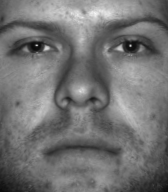
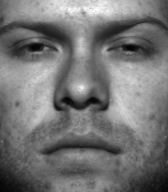
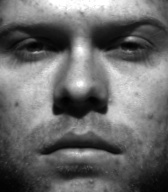
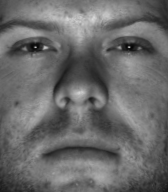
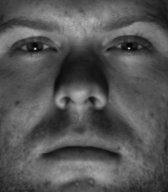
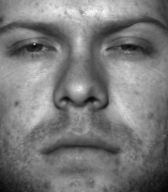
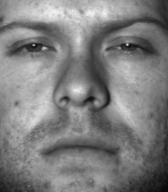
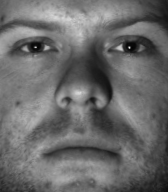

In [7]:
# Affichage des 8 photos de la première personne
load.(trainFileName[1:8])

,,,,,,,

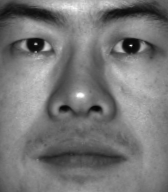
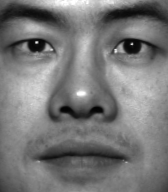
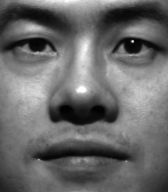
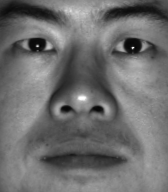
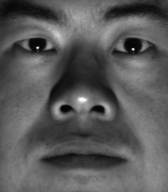
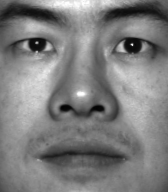
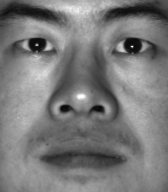
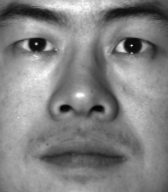

In [8]:
# Affichage des 8 photos de la deuxième personne
load.(trainFileName[29:36])

In [9]:
# Récupération de tous les noms de fichiers de l'échantillon d'entraînement
file = readdir("Test")
testFileName = ["Test/"*file[i] for i=1:length(file)];

,,,,,,,

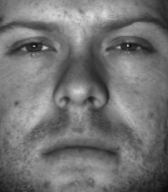
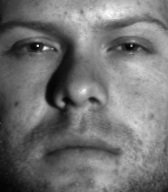
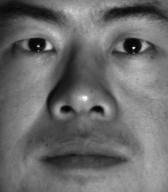
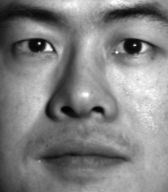
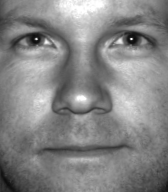
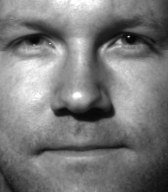
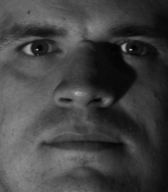
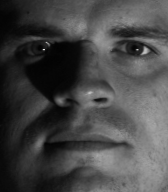

In [10]:
# Affichage des 8 premières images de l'ensemble de test
load.(testFileName[1:8])

In [11]:
length(testFileName)

69

### (a) Convertissez en matrice de niveaux de gris la première image

Utilisez pour ce faire la fonction `imgrayconvert` fournie.

In [12]:
X₁ = imgrayconvert(trainFileName[1])

192×168 Matrix{Float64}:
 0.313725   0.313725   0.329412   …  0.247059   0.262745   0.278431
 0.317647   0.309804   0.305882      0.235294   0.239216   0.25098
 0.313725   0.309804   0.321569      0.239216   0.231373   0.243137
 0.309804   0.317647   0.337255      0.239216   0.231373   0.247059
 0.313725   0.321569   0.32549       0.25098    0.235294   0.247059
 0.321569   0.341176   0.34902    …  0.243137   0.231373   0.235294
 0.309804   0.329412   0.345098      0.239216   0.223529   0.227451
 0.313725   0.321569   0.329412      0.247059   0.227451   0.219608
 0.32549    0.32549    0.321569      0.243137   0.215686   0.223529
 0.321569   0.321569   0.321569      0.247059   0.227451   0.227451
 0.305882   0.313725   0.329412   …  0.262745   0.243137   0.231373
 0.317647   0.321569   0.341176      0.258824   0.247059   0.231373
 0.321569   0.32549    0.329412      0.254902   0.254902   0.235294
 ⋮                                ⋱  ⋮                     
 0.141176   0.137255   0.12549  

### (b) Affichez la matrice des intensités de gris 

Utilisez la fonction `imshow` fournie.

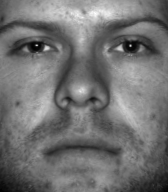

In [13]:
imshow(X₁)

### (c) Récupérez le nombre de lignes et le nombre de colonnes des images

Assignez les variables suivantes :
- `m₁` : le nombre de lignes d'une image;
- `m₂` : le nombre de colonnes d'une image ;
- `m` : le nombre total de pixels d'une image.

In [14]:
m₁, m₂ = size(X₁)

(192, 168)

In [15]:
m = m₁ * m₂

32256

### (d) Emmagasinez toutes les images dans une seule matrice X.

Chaque ligne de la matrice X correspond à une image. 

De façon analogue à la régression, la matrice X possède n observations (le nombre d'images) avec m variables explicatives (chacun des pixels).

In [16]:
# Préallocation de la matrice
X = Array{Float64,2}(undef,n,m)

for i=1:n
   X[i,:] = imgrayconvert(trainFileName[i], columnStack=true) 
end

### (e) Affichez la 29e image à partir de la matrice X

Utilisez la fonction `imshow` pour la 29e ligne de la matrice X.

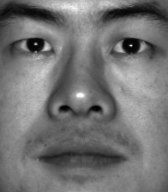

In [17]:
imshow(X[29,:], (m₁, m₂))

# 2. Analyse en composantes principales

Le but de cette section est de réduire la dimension du jeu de données d'entraînement, soit la matrice X. Nous ferons  une décomposition en valeurs singulières de cette matrice et nous récupérerons que les $k$ premières.

Les étapes sont les suivantes :
1. Centrer chacune des lignes de la matrice des visages d'entraînement pour obtenir la matrice $Z$.
2. Effectuer une décomposition en valeurs singulières de $Z$.
3. Illustrer le pourcentage de variabilité récupérée en fonction du nombre $k$ de composantes principales. 

## 2.1 Centrez les images de l'ensemble d'entraînement

### (a) Calculez le visage moyen $\bar{X}$ en faisait une moyenne de tous les visages pour chacun des pixels. Affichez le visage moyen avec la fonction `imshow`.

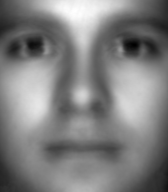

In [18]:
x̄ = vec(mean(X, dims=1))

imshow(x̄, (m₁, m₂))

### (b) Calculez la matrice $Z$ centrée des visages de l'ensemble d'entraînement. 

Ensuite, afficher la différence entre le premier visage et le visage moyen avec la fonction `imshow`.

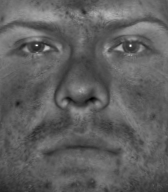

In [19]:
Z = X .- x̄'

imshow(Z[1,:], (m₁, m₂))

## 2.2 Décomposez en valeurs singulières la matrice $Z$.

### (a) Obtenez les matrices $U$ et $V$ ainsi que les valeurs singulières à l'aide de la fonction `svd`.

In [20]:
F = svd(Z)
V = F.V
U = F.U
γ = F.S;

### (b) Affichez les premiers vecteurs singuliers de $V$ avec la fonction `imshow`. 

Ces composantes représentent les modes de plus grande variabilité. Dans la reconnaissance faciale, elles sont appelées les *eigenfaces*.

,,,,,,,

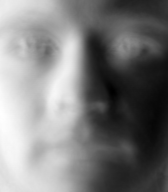
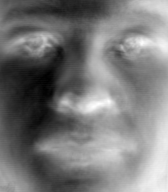
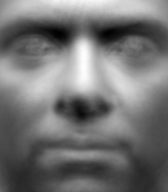
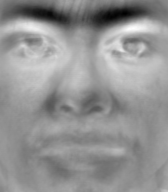
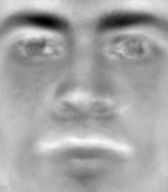
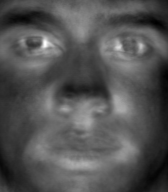
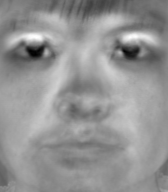
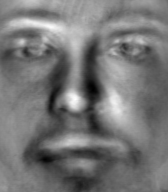

In [21]:
[imshow(V[:,i], (m₁, m₂)) for i=1:8]

## 2.3 Illustrez le pourcentage de variabilité récupérée en fonction du nombre $k$ de composantes principales.

### (a) Tracez un graphique permettant de voir le pourcentage de la variance totale retenue en fonction du nombre de composantes principales.

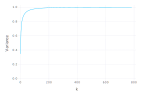

In [22]:
cumvar = cumsum(γ.^2)

ratio = cumvar / cumvar[end]

df = DataFrame(k = Int64[], Variance = Float64[])

for k in 1:length(ratio)
    push!(df, [k, ratio[k]])
end

plot(df, x=:k, y=:Variance, Geom.line)

### (b) Calculez le pourcentage de la variance récupérée en utilisant les $k$ premières composantes principales.

Utilisez les valeurs de k dans l'ensemble {8, 78, 196, 392} qui correspondent respectivement à des tailles de matrice ayant 1%, 10%, 25% et 50% de la taille de la matrice originale. 

In [23]:
ratio[[8, 78, 196, 392]]

4-element Vector{Float64}:
 0.7801981312721126
 0.9671982550371403
 0.9905756731927182
 0.9976165248816946

# 3. Approximation des images avec les composantes principales

## 3.1 Approximation de la première image de l'ensemble d'entraînement

### (a) Calculez la combinaison linéaire des $k=8$ premières principales qui approxime le mieux l'image 1 de l'ensemble d'entraînement.

Pour ce faire, trouvez le meilleur plan qui recoupe les pixels de l'image 1. Indice : pensez à la régression linéaire.



In [24]:
k = 8
i = 1

zᵢ = Z[i, :]
Vₖ = V[:, 1:k]

32256×8 Matrix{Float64}:
  0.00534734  -0.00593475    0.000738375  …  -0.00582486    0.00216331
  0.00540604  -0.00593016    0.000760127     -0.00554808    0.00245346
  0.00544098  -0.00581651    0.000862511     -0.00556005    0.00259157
  0.0054438   -0.00578868    0.000988561     -0.00553916    0.00202386
  0.00542277  -0.00569403    0.00114588      -0.00525945    0.00162572
  0.00546097  -0.00558436    0.00125364   …  -0.00472253    0.00179686
  0.00549627  -0.00555629    0.0013483       -0.00424513    0.00181623
  0.00554805  -0.00550439    0.00151448      -0.0033266     0.00163532
  0.00557532  -0.00557535    0.00162796      -0.00262822    0.00141706
  0.00559203  -0.00540729    0.00162903      -0.00227461    0.00131903
  0.00555506  -0.00540267    0.00170837   …  -0.00171927    0.00126604
  0.00558824  -0.00531072    0.00194505      -0.00115108    0.000965275
  0.00558341  -0.00531839    0.00201843      -0.000682609   0.000899504
  ⋮                                       ⋱       

In [37]:
# La combinaison linéaire des k premières composantes principales qui approxime le mieux zᵢ
@time η̂ᵢₖ = Vₖ\zᵢ

# Or puisque Vₖ est une matrice orthonormale, son inverse est égal à sa transposée. On a alors de façon plus efficace
@time η̂ᵢₖ = Vₖ'zᵢ

  0.001119 seconds (67 allocations: 2.286 MiB)
  0.000093 seconds (2 allocations: 144 bytes)


8-element Vector{Float64}:
 -4.868316659849873
 -9.508065966515462
 -0.5404498552677293
 -4.07848185776805
 -0.9771113301165377
  1.651492140080556
 -1.573509440860321
  1.3784192719968127

In [39]:
@time γ[1:k].*U[1,1:k]

  0.000021 seconds (7 allocations: 512 bytes)


8-element Vector{Float64}:
 -4.8683166598500645
 -9.508065966515709
 -0.5404498552675359
 -4.078481857767917
 -0.9771113301164485
  1.651492140080517
 -1.5735094408602492
  1.3784192719967954

### (b) Calculez l'approximation obtenue

In [26]:
ẑᵢ = Vₖ*η̂ᵢₖ

32256-element Vector{Float64}:
  0.03041287951998328
  0.030371725342701217
  0.031132048855815386
  0.03284319658184404
  0.03427504851589181
  0.03479230039255036
  0.034180014384606
  0.033359483326980674
  0.034210280188562134
  0.031768324454855015
  0.03200371427177576
  0.030952175208332537
  0.030155822413218278
  ⋮
  0.006150397712868991
  0.0036681199277483582
  0.0023007391485448565
  0.0014956415546902892
 -0.0008522471884649593
 -0.0024775373604299517
 -0.0024133795671197333
 -0.0014354746878136402
 -0.0022771230091859686
 -0.006892092679464883
 -0.0215113629350517
 -0.031208056375210923

### (c) Affichez l'image $zᵢ$ originale ainsi que son approximation

Vous pouvez ajouter le visage moyen pour une meilleure interprétation

,

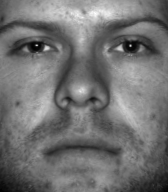
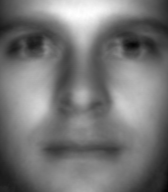

In [27]:
[imshow(zᵢ + x̄, (m₁, m₂)), imshow(ẑᵢ + x̄, (m₁, m₂))]

In [28]:
ẑᵢ = vec(U[1,1:k]'*diagm(γ[1:k])*V[:, 1:k]')

32256-element Vector{Float64}:
  0.030412879519984625
  0.030371725342702532
  0.031132048855816993
  0.03284319658184577
  0.03427504851589382
  0.03479230039255142
  0.03418001438460798
  0.03335948332698236
  0.034210280188564465
  0.031768324454857444
  0.03200371427177913
  0.030952175208334938
  0.030155822413218583
  ⋮
  0.006150397712869217
  0.003668119927748577
  0.002300739148545051
  0.0014956415546905528
 -0.0008522471884647234
 -0.0024775373604296845
 -0.0024133795671195946
 -0.0014354746878135292
 -0.00227712300918583
 -0.006892092679464581
 -0.021511362935051053
 -0.031208056375209993

,

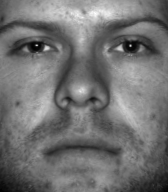
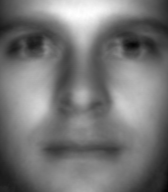

In [29]:
[imshow(zᵢ + x̄, (m₁, m₂)), imshow(ẑᵢ + x̄, (m₁, m₂))]

## 3.2 Approximation du visage 1 avec les 78 premières composantes principales

Reprenez les étapes précédentes mais cette fois en utilisant les 78 premières composantes principales.

In [30]:
i = 1
k = 78

Vₖ = V[:,1:k]
zᵢ = Z[i,:]

32256-element Vector{Float64}:
  0.06894257703081225
  0.07191376550620246
  0.06781712685074034
  0.06590136054421766
  0.07182372949179672
  0.0795618247298919
  0.06677671068427371
  0.06938275310124051
  0.08125750300120047
  0.07941176470588235
  0.06563625450180074
  0.0779511804721888
  0.08214285714285716
  ⋮
 -0.058038215286114345
 -0.04533813525410156
 -0.054521808723489384
 -0.055477190876350516
 -0.01741696678671467
 -0.05705282112845132
 -0.07835134053621441
 -0.08707482993197278
 -0.10192076830732287
 -0.09803421368547416
 -0.10303621448579428
 -0.11860244097639051

,

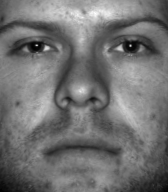
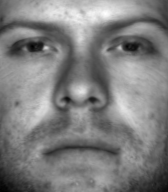

In [31]:
η̂ᵢₖ = Vₖ'zᵢ 

ẑᵢ = Vₖ*η̂ᵢₖ 

[imshow(zᵢ + x̄, (m₁, m₂)), imshow(ẑᵢ + x̄, (m₁, m₂))]

L'approximation à droite est obtenue avec une matrice de taille environ 10 fois moins volumineuse que le jeu de données original.

## 3.3 Approximation du visage 29 avec les 78 premières composantes principales

Reprenez les étapes précédentes mais cette fois avec le visage 29.

In [32]:
i = 29
k = 78

Vₖ = V[:,1:k]
zᵢ = Z[i,:]

32256-element Vector{Float64}:
  0.09247198879551816
  0.06407062825130053
  0.05605242096838739
  0.046293517406962775
  0.040451180472188875
  0.0364245698279311
  0.023639455782312913
 -0.0090486194477791
 -0.012860144057623063
 -0.05000000000000002
 -0.07554021608643458
 -0.0985194077631053
 -0.090406162464986
  ⋮
  0.2164715886354543
  0.21348539415766313
  0.20430172068827535
  0.20334633853541417
  0.21003401360544222
  0.19000600240096044
  0.1843937575030013
  0.18743497398959585
  0.1804321728691477
  0.1725540216086435
  0.16755202080832338
  0.15982893157262912

,

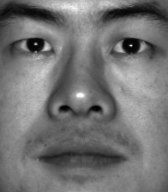
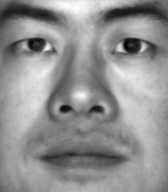

In [33]:
η̂ᵢₖ = Vₖ'zᵢ 

ẑᵢ = Vₖ*η̂ᵢₖ 

[imshow(zᵢ + x̄, (m₁, m₂)), imshow(ẑᵢ + x̄, (m₁, m₂))]

## 3.4 Approximation du visage 1 avec toutes les composantes principales

Reprenez les étapes précédentes mais cette fois en utilisant toutes les composantes principales.

In [34]:
i = 1
k = n

Vₖ = V[:,1:k]
zᵢ = Z[i,:];

,

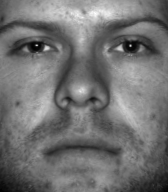
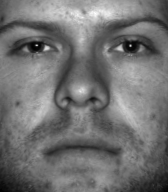

In [35]:
η̂ᵢₖ = Vₖ'zᵢ 

ẑᵢ = Vₖ*η̂ᵢₖ 

[imshow(zᵢ + x̄, (m₁, m₂)), imshow(ẑᵢ + x̄, (m₁, m₂))]

## 3.5 Approximation de tous les visages de l'ensembles d'entraînement

En prenant les $k = 78$ premières composantes principales, calculez les pondérations η̂ᵢₖ permettant d'approximer tous les visages de l'ensemble d'entraînement. Construisez la matrice $H$ de taille $k \times n$ où la $i^e$ colonne correspond à la combinaison linéaire qui approxime l'image $i$ avec les $k$ premières composantes principales η̂ᵢₖ.


In [36]:
k = 78

Vₖ = V[:,1:k];

In [37]:
H = Vₖ'Z'

78×784 Matrix{Float64}:
 -4.86832     -6.48185    -5.99773   …  -55.9969    -46.4065     -42.4921
 -9.50807    -12.7425     -7.85642       12.2925     16.751       22.4158
 -0.54045     11.1566     24.9962         1.49181    15.3049     -17.6988
 -4.07848     -3.07518    -1.00458        3.96216     3.53984      3.11739
 -0.977111    -1.2877     -2.35372       13.8613     12.477        9.11448
  1.65149      0.395396   -3.64181   …   -7.50001    -9.75149     -6.56673
 -1.57351     -0.256292    0.218222      -2.29773    -0.0405152    1.58401
  1.37842      1.53876     2.27855       -1.15949     2.0087      -5.939
 -0.715534    -3.71651    -5.57643       -1.56275     0.179863    -3.16811
  4.22145      3.92626     0.911734       4.73462     7.30706     -2.3729
 -0.520365    -0.211523    0.117357  …    2.90449     3.69986      6.17426
  3.92009      3.72606     3.05445        4.67709     2.00815      2.27071
 -3.18866     -2.72529    -0.830075      -5.32523    -3.1992      -4.70198
  ⋮    

# 4. Reconnaissance faciale


L'idée de la reconnaissance faciale consiste à comparer le vecteur des coefficient $\mathbf{\hat{\eta}}$ de l'image à reconnaître avec les coefficients des images de l'ensemble d'entraînement. C'est une comparaison assez facile à faire car ce vecteur est de dimension raisonnable comparativement aux images originales. En effet, dans notre cas, si on prend 78 composantes principales, le vecteur des coefficients est un vecteur colonne de taille 78. On peut donc résumer toutes les images par leur vecteur des coefficients de taille 78. 

Pour savoir, si une nouvelle image représente une personne présente dans l'ensemble d'entraînement, on n'a qu'à comparer son vecteur des coefficients avec chacun des vecteurs des coefficients de l'ensemble d'entraînement. Si la différence entre les vecteurs est très grande, cela suggère que la personne est inconnue de l'ensemble d'entraînement. Si la différence est petite avec un des vecteurs de coefficients, cela suggère qu'il s'agit de la même personne. Le seuil doit être ajusté par une procédure de validation croisée.

Dans cette section, vous déciderez si une nouvelle image de l'ensemble test représente un personne connue ou inconnue. Vous le ferez en complétant les étapes suivantes :

1. Calculez les coefficients de la combinaison linéaire des colonnes de Vₖ approximant l'image inconnue zₒ.
2. Calculez la distance euclidienne entre les coefficients des images d'entraînement et celui de l'image de test.
3. Identifiez l'image de l'ensemble d'entraînement la plus proche de l'image de test.
4. En fonction de la distance, décidez si le visage se retrouve dans l'échantillon d'entraînement ou s'il est inconnu.

## 4.1 Calculez les coefficients de la combinaison linéaire des colonnes de Vₖ approximant  l'image inconnue zₒ.

Prenez $k = 78$ composantes.

### (a) Chargez une image de l'ensemble de test

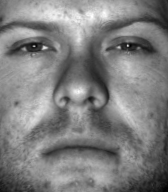

In [38]:
# jᵉ image de l'ensemble de test
j = 1

# chargement de la matrice des niveaux de gris
xₒ = imgrayconvert(testFileName[j], columnStack=true)

# Affichage de l'image brute
imshow(xₒ, (m₁, m₂))

### (b) Calculez la différence avec le visage moyen

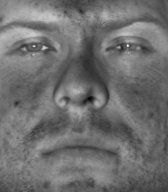

In [39]:
# Calcul de la différence avec le visage moyen
zₒ = xₒ - x̄

# Affichage des différences
imshow(zₒ, (m₁, m₂))

### (c) Calculez les coefficients de la combinaison linéaires de Vₖ qui approxime le mieux zₒ

In [40]:
η̂ₒ = Vₖ'zₒ

78-element Vector{Float64}:
   1.383891533381266
 -11.301848126779355
  -5.797946060806525
  -4.228812554733782
  -1.314319983303179
   2.193900703038049
  -1.53016003532216
   3.0229522631766854
  -1.866831398022064
   4.420555874908388
  -1.984659905933576
   3.7015862953389886
  -4.492697779785973
   ⋮
  -0.020023247327222105
   0.4853504259312864
   0.02615470995774688
  -0.024484249997102154
  -0.05436974867437862
   0.5729818486953339
   0.6747380062510799
  -0.4200422268971713
   0.35326221118010126
  -0.4226915095412995
  -0.8646729821801415
   0.20432840536603905

### (d) Calculez les vecteurs différences entre les coefficients de l'image et ceux de l'ensemble d'entraînement

In [41]:
# Calcul du vecteur différence avec tous les coefficients des images de l'ensemble d'entraînement
e = H .- η̂ₒ

78×784 Matrix{Float64}:
 -6.25221    -7.86574    -7.38162   -2.51194    …  -47.7903     -43.8759
  1.79378    -1.44062     3.44543    8.98762        28.0528      33.7177
  5.2575     16.9545     30.7942    -4.18501        21.1028     -11.9009
  0.150331    1.15363     3.22424   -0.158883        7.76865      7.34621
  0.337209    0.0266217  -1.0394     0.322615       13.7913      10.4288
 -0.542409   -1.7985     -5.83571   -0.174315   …  -11.9454      -8.76064
 -0.0433494   1.27387     1.74838    0.0949881       1.48964      3.11417
 -1.64453    -1.48419    -0.744401  -0.434986       -1.01425     -8.96195
  1.1513     -1.84968    -3.7096     1.13855         2.04669     -1.30128
 -0.199104   -0.4943     -3.50882   -0.250637        2.8865      -6.79346
  1.46429     1.77314     2.10202    0.140799   …    5.68452      8.15892
  0.218503    0.0244762  -0.647141   0.458556       -1.69344     -1.43088
  1.30404     1.7674      3.66262   -0.033798        1.2935      -0.209284
  ⋮              

### (e) Calculez la norme euclidienne de ces vecteurs différence

In [42]:
# Calcul de la norme euclidienne des vecteurs de différence
d = vec(sum(e.^2, dims=1))
    
# Calcul la norme minimale et l'indice de la composante
min_e, ind = findmin(d)

(96.96060116467127, 1)

### (f) Identifiez l'image de l'ensemble d'entraînement pour laquelle la norme des différences est la plus petite.

Conservez la norme de la différence minimale.

,

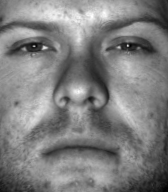
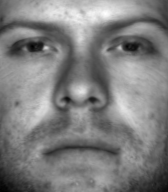

In [43]:
# Affichage de l'image de test ainsi que de l'image la plus proche
[imshow(xₒ, (m₁, m₂)),  imshow(Vₖ*H[:,ind] + x̄, (m₁, m₂))]

### (g) Décidez si le visage se retrouve dans l'échantillon d'entraînement ou s'il est inconnu.

Si la distance minimale de la différence est suffisamment petite, alors on statuera que la personne est connue (elle se retrouve dans l'ensemble d'entraînement). Sinon, la personne est inconnue (elle ne se retrouve pas dans l'ensemble d'entraînement).

Il faut définir ce seuil à l'aide d'une procédure validation croisée. Par simplicité ici, utilisez le seuil de 3500².

Vous pouvez refaire les étapes du numéro 4 avec les autres images de l'ensemble de test et vous pouvez même tenter d'utiliser un nombre différent de composantes principales. Amusez-vous !  

In [44]:
# Décision : est-ce que la personne sur l'image de test se trouve dans l'ensemble d'entraînement ?

if min_e < 3500^2
    println("La personne est connue.")
else
    println("La personne est inconnue.")
end

La personne est connue.
